In [1]:
learnMSA_path = "../../tmp_work/learnMSA" #ignore if learnMSA is already installed via pip/conda

import sys
sys.path.insert(0, learnMSA_path)
import os
import shutil
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Size scaling evaluation

Principle: The depth (= number of aligned sequences) should not negatively, at best positively, affect the accuracy of a multiple alignment.

To test this, we embed a set of sequences with known reference MSA into nested random sets of homologs with increasing size. 

In [ ]:
train_path = "../data/ext_homfam_huge/train/" 
refs_path = "../data/ext_homfam_huge/refs/" 

full_datasets = [] #unaligned homologs
ref_msas = [] #refrence alignments 

for file in os.listdir(os.fsencode(train_path)):
    filename = os.fsdecode(file)
    ds = SequenceDataset(train_path+filename, fmt="fasta")
    ref = SequenceDataset(refs_path+filename, fmt="fasta")
    full_datasets.append(ds)
    ref_msas.append(ref)

In [5]:
for ds, ref in zip(full_datasets[:10], ref_msas[:10]):
    print(ds.filename.ljust(50), " total num seqs:", ds.num_seq, "\t num ref seqs:", ref.num_seq)

../data/ext_homfam_huge/train/HATPase_c             total num seqs: 1105608 	 num ref seqs: 6
../data/ext_homfam_huge/train/PAS                   total num seqs: 459813 	 num ref seqs: 3
../data/ext_homfam_huge/train/igC1                  total num seqs: 257516 	 num ref seqs: 5
../data/ext_homfam_huge/train/sugbp                 total num seqs: 348308 	 num ref seqs: 4
../data/ext_homfam_huge/train/helicase_NC           total num seqs: 932215 	 num ref seqs: 3
../data/ext_homfam_huge/train/alpha-amylase_NC      total num seqs: 258184 	 num ref seqs: 23
../data/ext_homfam_huge/train/Extradiol_dioxy       total num seqs: 376670 	 num ref seqs: 3
../data/ext_homfam_huge/train/kinase                total num seqs: 949994 	 num ref seqs: 15
../data/ext_homfam_huge/train/ANK                   total num seqs: 380510 	 num ref seqs: 3
../data/ext_homfam_huge/train/mdd                   total num seqs: 871924 	 num ref seqs: 3


### Sample $n$ sequences of nested random sets per family 

In [6]:
def sample_subset(fasta, ref_fasta, old_indices, subset_size):
    assert subset_size < old_indices.size, "The sampled subset has to be smaller than the old subset."
    ref_indices = np.array([fasta.seq_ids.index(sid) for sid in ref_fasta.seq_ids])
    for i in ref_indices:
        assert np.where(old_indices == i)[0].size == 1, f"Ref. index {i} is either not at all or multiple times in the old indices array."
    homolog_indices = np.setdiff1d(old_indices, ref_indices)
    homolog_subset = np.random.choice(homolog_indices, size=subset_size-ref_indices.size, replace=False)
    return np.concatenate([ref_indices, homolog_subset], axis=0)


def make_paths(fasta, subset, k):
    family = os.path.splitext(os.path.basename(fasta.filename))[0]
    subset_train_path = f"data/size_scaling/train/{family}_{subset.size}_{k}"
    subset_ref_path = f"data/size_scaling/refs/{family}_{subset.size}_{k}"
    return subset_train_path, subset_ref_path
    

def gen_fasta(fasta, subset, k):
    subset_train_path, subset_ref_path = make_paths(fasta, subset, k)
    if not os.path.exists(subset_train_path):
        # write the subset fasta
        with open(subset_train_path, "w") as train_file:
            for i in subset:
                train_file.write(">"+fasta.seq_ids[i]+"\n"+str(fasta.get_record(i).seq)+"\n")
        # copy the reference msa
        family = os.path.splitext(os.path.basename(fasta.filename))[0]
        shutil.copyfile("../data/ext_homfam_huge/refs/"+family, subset_ref_path)

In [7]:
!mkdir -p data/size_scaling/train
!mkdir -p data/size_scaling/refs

In [8]:
np.random.seed(94) 

#number of independent experiments
num_samples = 4 

#defines total subsets sizes (references + homologs) used for the experiments
subset_sizes = [int(i) for i in [1e3, 1e4, 5e4, 1e5, 2.5e5]]

In [34]:
#nested datastructure for the precomputed random subsets
subsets = []
for fasta, ref_fasta in zip(full_datasets, ref_msas):
    indices = [ [np.arange(fasta.num_seq) for _ in range(num_samples)] ]
    for size in reversed(subset_sizes):
        indices.append([])
        for ind in indices[-2]:
            subset = sample_subset(fasta, ref_fasta, ind, size)
            indices[-1].append(subset)
    subsets.append(indices[1:])

In [35]:
#generate sampled files 
for fasta, subsets_by_size in zip(full_datasets, subsets):
    for subset_by_size in subsets_by_size:
        for k, sample in enumerate(subset_by_size):
            gen_fasta(fasta, sample, k)

In [ ]:
# align all subsampled files with snakemake

### Plots

In [3]:
def load_data(tool):
    df = pd.read_csv("results/"+tool+".out", index_col=False, sep=' ', names=["dataset", "key", "num_seq", "num_ref_seq", "avg_len", "avg_ref_len", "sim", "SP", "modeler", "TC", "column", 
                                                    "s", "h:m:s", "max_rss", "max_vms", "max_uss", "max_pss", "io_in", "io_out", "mean_load", "cpu_time"])
    df["tool"] = tool
    split = df.key.str.split('_', n=-1, expand=True)
    df["sample_index"] = df.key.map(lambda x: x.split("_")[-1])
    df["sample_size"] = df.key.map(lambda x: x.split('_')[-2])
    df["family"] = df.key.map(lambda x: "_".join(x.split('_')[:-2]))
    df = df.set_index(df.dataset + "_" + df.key)
    return df

In [7]:
homfam_families = list(os.listdir("../data/homfam/refs/"))
homfam_families.sort()

In [8]:
homfam_ext_huge_families = list(learnMSA.family.unique())
homfam_ext_huge_families.sort()

In [9]:
overlap = [f for f in homfam_ext_huge_families if f in homfam_families]

In [10]:
# returns averages scores and standard deviations for each subset size
def get_avg(data, score_type = "TC", count_failed_as_zero = True):
    sample_sizes = data.sample_size.unique()
    sample_sizes = [int(s) for s in sample_sizes]
    sample_sizes.sort()
    averages = []
    standard_deviations = []
    for s in sample_sizes:
        subset = data[data.sample_size == str(s)]
        if not count_failed_as_zero:
            subset = subset[(subset.SP != 0) | (subset.TC != 0) | (subset.modeler != 0) | (subset.column != 0)]
        averages.append(subset.groupby("family")[score_type].mean().mean())
        standard_deviations.append(subset.groupby("family")[score_type].std().mean())
    return sample_sizes, np.array(averages), np.array(standard_deviations)

In [11]:
tools = ["learnMSA", "learnMSA_language", "famsa", "t_coffee", "clustalo", "muscle", "mafft"]

In [12]:
full_data = pd.concat([load_data(tool) for tool in tools], ignore_index=True)
full_data

,dataset,key,num_seq,num_ref_seq,avg_len,avg_ref_len,sim,SP,modeler,TC,...,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,tool,sample_index,sample_size,family
0,size_scaling,igvar-h_250000_3,250000,21,76.9863,137,52.1,68.0,79.1,28.9,...,29457.57,29780.32,5.87,2141.44,1358.76,5008.34,learnMSA,3,250000,igvar-h
1,size_scaling,PA_phosphatase_50000_3,50000,3,188.2950,353,39.9,59.0,61.4,38.7,...,29808.59,30131.75,6.88,872.98,2220.96,16660.53,learnMSA,3,50000,PA_phosphatase
2,size_scaling,igI_250000_0,250000,9,77.0300,141,15.5,60.2,68.8,18.1,...,30014.77,30337.53,9.78,1904.50,1649.23,24051.20,learnMSA,0,250000,igI
3,size_scaling,molybdopterin_1000_3,1000,4,249.8870,836,39.3,54.4,69.7,38.2,...,26461.25,26782.76,7.86,26.59,1001.39,2387.15,learnMSA,3,1000,molybdopterin
4,size_scaling,Extradiol_dioxy_1000_3,1000,3,118.0830,319,35.3,73.7,75.8,59.5,...,24882.34,25202.74,5.64,6.52,504.23,1307.90,learnMSA,3,1000,Extradiol_dioxy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8675,size_scaling,Extradiol_dioxy_10000_2,10000,3,118.4870,319,35.3,32.1,61.1,15.1,...,108.37,110.64,0.00,2.84,85.12,53.51,mafft,2,10000,Extradiol_dioxy
8676,size_scaling,Cyclodex_gly_tran_250000_2,250000,6,182.6090,707,63.0,47.9,85.2,16.6,...,11701.87,11703.74,0.00,10958.42,98.81,67.99,mafft,2,250000,Cyclodex_gly_tran
8677,size_scaling,transketolase_PC_250000_0,250000,3,141.6640,398,26.4,12.5,37.8,1.5,...,2999.08,3000.96,0.00,1236.48,97.28,22.14,mafft,0,250000,transketolase_PC
8678,size_scaling,PA_phosphatase_50000_1,50000,3,188.5420,353,39.9,52.7,80.0,33.4,...,1969.72,1971.59,0.00,1677.32,96.77,16.35,mafft,1,50000,PA_phosphatase


In [13]:
tools = ["learnMSA_language", "learnMSA", "famsa", "t_coffee", "clustalo", "muscle", "mafft"]
tool_names = ["learnMSA2", "learnMSA 1.3", "FAMSA", "T-Coffee (regressive)", "Clustal Omega", "MUSCLE", "MAFFT"]
tool_colors = [sns.color_palette("dark")[i] for i in [2, 1, 3, 4, 8, 5, 6]] #chosen to match the colors of the other plots

def make_data_harms_plot(ax, score_type = "SP", count_failed_as_zero = True, no_labels=False, show_legend=True):
    for i, (tool, name, color) in enumerate(zip(tools, tool_names, tool_colors)):
        data = load_data(tool)
        #keep only overlap
        #data = data[data.family.isin(overlap)]
        #keep only dissimilar sequences
        #data = data[data.sim <= 40]
        sizes, avg, sd = get_avg(data, score_type, count_failed_as_zero)
        m = len(sizes)
        ax.plot(range(m), avg, "--o", markersize=10, linewidth=2, color=color, label=name)
        #shaded area
        ax.fill_between(range(m), avg-sd/2, avg+sd/2, color=color, alpha=.0)
        #label with difference of first and last points
        decline = np.round(avg[-1] - avg[0], 1)
        ax.annotate(str(decline), 
                    xy=(m-0.9, avg[-1]),
                    fontsize=10,
                    color=color)
        
    ax.grid(linestyle='--', linewidth=1, axis="y", alpha=0.5)
    ax.set_xticks(range(m), sizes)
    ax.set_xlim(-0.5, m-0.3)
    if score_type == "TC":
        ax.set_ylim(20, 50)
    else:
        ax.set_ylim(36, 71)
    ax.set_xlabel("number of sequences")
    ax.set_ylabel(score_type+" score")
    if show_legend:
        ax.plot([], [], ' ', label=f"{data.family.nunique()} families\n{data.sample_index.nunique()} random samples")
        ax.legend(loc="lower left", fontsize=12)

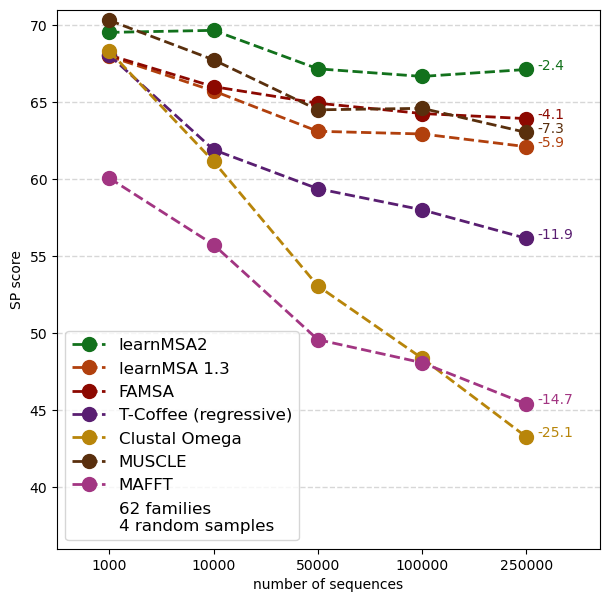

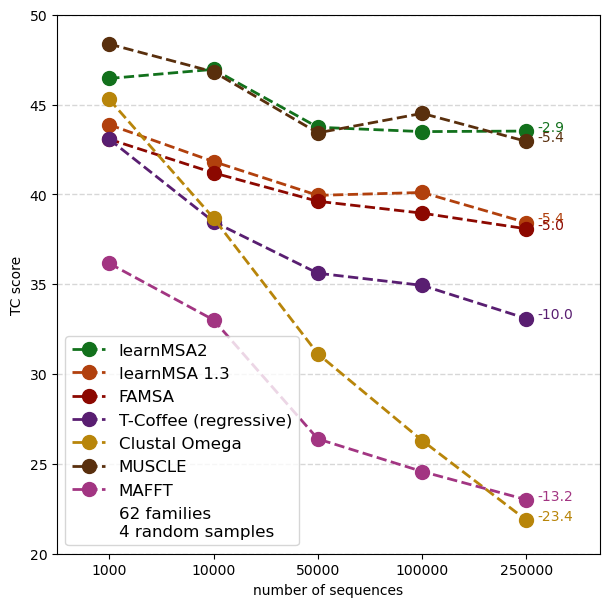

In [14]:
fig, ax = plt.subplots(1,1, figsize=(7, 7))
make_data_harms_plot(ax, "SP")
plt.savefig("size_scaling_SP.pdf", bbox_inches='tight')

fig, ax2 = plt.subplots(1,1, figsize=(7, 7))
make_data_harms_plot(ax2, "TC")
plt.savefig("size_scaling_TC.pdf", bbox_inches='tight')

### Experiment discription

We analyse the effect on alignment accuracy when embedding a static set of reference sequences into increasing, nested numbers of homologs.\
As in our other experiments, the combined sequence sets are aligned and consequently the induced subalignment of the references\
is compared to the corresponding reference alignment. 

For each family, we embed the references in nested sets of homologs of increasing size. We repeat this sampling precedure multiple times and average the results over all experiments and\
families. The shaded area are the standard deviations over the multiple samples, averaged over the families.

For each analysed protein family, this notebook requires a reference alignment and the entire unaligned sequence set of family members (including the unaligned references).